Author: Carlos Roberto de Melo

Date: 05/27/2020

Obj: Perform the modeling of spectrum based on pPXF method by Cappellari,and obtein the kinematics./Realizar o modelamento de espectros baeado no código pPXF de Cappellari, e obter a cinemática.

In [2]:
import glob
from os import path

from astropy.io import fits
from scipy import ndimage
import numpy as np

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

import matplotlib.pyplot as plt

data_folder = "/home/carlos/Desktop/ESO"

 Best Fit:       Vel     sigma
 comp.  0:      -303       381
chi2/DOF: 0.7828
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 150


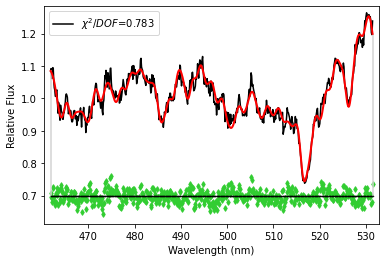

0
Vel :-302.759824.
Disp:380.813705.
Best-fitting redshift z: 0.29768814240852337

####################

 Best Fit:       Vel     sigma
 comp.  0:      -316       385
chi2/DOF: 2.247
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 150


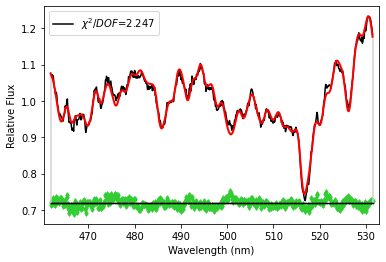

1
Vel :-316.447820.
Disp:384.659695.
Best-fitting redshift z: 0.2976288323571099

####################



<Figure size 432x288 with 0 Axes>

In [4]:
ppxf_dir = '/home/carlos/Desktop/ppxf' #Directory of stellar library/Diretória da biblioteca estelar

for i in range(2):
     #READING THE SPECTRUM/LENDO UM ESPECTRO
    file = (data_folder+'/Data/Binned_Spec/Bin%d.fits'%i) #Path and name of the spectrum/Caminho e nome do arquivo do espectro
    hdu = fits.open(file) #Opening the .fits file/Abrindo o arquivo.fits
    gal_lin = hdu[1].data #Read the data/Lendo os dados
    h1 = hdu[1].header    #Read the header/Lendo o header dos dados
    
    #READING THE VARIANCE/LENDO A VARIÂNCIA DO ESPECTRO
    var = hdu[2].data     #Read the variance/Lendo a variância
    h_var = hdu[2].header #Read the variance header/Lendo o header da variância
    
    #LOG-REBIN THE SPECTRUM AND VARIANCE/LOGARITMIZANDO O ESPECTRO E A VARIÂNCIA
        #SPECTRUM/ESPECTRO
    FWHM_gal = 2.71  #FWHM of telescope in Angstrons/FWHM do telescópio em Angstrons
    lambRange1 = h1['CRVAL1'] + np.array([0.,h1['CDELT1']*(h1['NAXIS1']-1)]) #Generating the wavelengths/Está linha gera os comprimentos de onda
                                #pois a variável gal_lin armazena em um array apenas as intensidades, mas não os comprimentos de onda
        
    #De-redshift
    z = 0.035 # Initial estimate of the galaxy redshift
    lambRange1 = lambRange1/(1+z) # Compute approximate restframe wavelength range
    FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom
    #Depois do passo acima, a galáxia passa a estar no restframe, logo é preeciso setar
    z = 0.
    
    
    galaxy, logLam1, velscale = util.log_rebin(lambRange1, gal_lin) #Log-rebin the spectrum/Logaritimizando o espectro da galáxia
    median_galaxy = np.median(galaxy) #Mean of spectrum for normalization/Média do espectro, pois vamos normalizá-lo pela média
    galaxy = galaxy/median_galaxy        #Normalizing the spectrum/Normalizando o espectro pela média
    lam = np.exp(logLam1)                #Recovering the wavelength in Ansgstrons/Recuperando o comprimento de onda em unidades do SI
        
    #VARIANCE/VARIÂNCIA
    lamRange_var = h_var['CRVAL1'] + np.array([0.,h_var['CDELT1']*(h_var['NAXIS1']-1)])
    erro = np.sqrt(var) #1-sigma error from variance/1-sigma erro da variância
    erro, loglam_var, velscale_var = util.log_rebin(lamRange_var, erro)
    noise = erro/median_galaxy         #Normalizing the error/Normalizando o erro        
        
    #READING ONE TEMPLATE FOR DETERMINE THE LENGHT/LENDO UM TEMPLATE PARA SABER O TAMANHO DO VETOR FINAL
        #The ideia is make a empty array to after complete with the informations about the templates of the stellar libary/
                    #A ideia é crirar um array vazio para que mais tarde seja preenchido com as informações de todos os templetes.
    vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') 
    FWHM_tem = 2.51  #FWHM of templates in Angstrons/FWHM do templete em Angstrons
    velscale_ratio = 2
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    #Log_rebin TEMPLATE/LOGARITMIZANDO O TEMPLATE
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
    templates = np.empty((sspNew.size, len(vazdekis)))  #Array with necessary size/Array com o tamanho necessário
    
    #FINAL FWHM FOR GALAXY AND TEMPLATE CONVOLUTION/CALCULANDO A FWHM FINAL PARA REALIZAR A CONVOLUÇÃO DO TEMPLATE E GALÁXIA
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1'] #New sigma PSF/Novo sigma da PSF.
    
    #READING ALL TEMPLATES/LENDO TODOS OS TEMPLATES E JÁ LOGARITMIZANDO
    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        #ssp = ndimage.gaussian_filter1d(ssp, sigma) #Convolution/Realizando a convolução
        sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
        templates[:, j] = sspNew/np.median(sspNew)
        
        
    #ADICIONANDO UM SHIFT PARA COINCIDIR OS COMPRIMENTOS DE ONDA DO ESPECTRO E DO TEMPLATE
        #Artificial shift for the galaxy and templates wavelenght may coincide.    
        #Nem sempre os comprimentos de onda do templete e do espectro coincidem, por esse motivo é dado um 
        #shift artificial ao templete, mas que após o ajuste é retirado.
    c = 299792.458 #Speed of light/Velocidade da Luz
    dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c #Shift
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)  #Mask bad emission lines/Máscaras para linhas de emissão
    vel = c*np.log(1 + z)
    start = [vel, 200.] #Inicial guess/Chute inicial
    
    #START OF FIT/INÍCIO DO AJUSTE
       #For each spectrum the modeling is done. After the best solution is printed 
       #(velocity, velocity dispersion, another moments). Then, a table is write with the information about the
       #pixel position, velocity, velocity dispersion, chi²/DOF and 1-sigma error. The table is saved with name
       #'Output_Ppxf.txt'.  
        
       #Para cada espectro ele realiza o ajuste e printa abaixo o nome do px em que foi realizado o ajuste,
       #bem como as infomações do melhor ajuste (qui², Velocidade, Dispersão, Demais momentos). Então cria uma
       #tabela com as informações necessárias e a salva com o nome 'Output_Ppxf.txt'.
    pp = ppxf(templates, galaxy, noise, velscale, start,
                lam = lam, plot=False, moments=2,
                  degree=6,vsyst=dv,  velscale_ratio=velscale_ratio)
        #For more informations about the method, visit the paper of Cappellari avaible in README
        #Para mais informações sobre o método, visite o paper de Cappellari disponível no README
        
        #Plot and save the best model/Plota e salva o melhor modelo
    pp.plot() #Plot the fit/Plota o fit
    plt.legend(["$\\chi^2/DOF$=%.3f"%pp.chi2])
    plt.savefig(data_folder+'/Data/Spec_Fit_Miles/Bin%d.png'%i,format='png')
    plt.show()
    plt.clf()
    print(i)
    print('Vel :%f.\nDisp:%f.'%(pp.sol[0],pp.sol[1]))
    print('Best-fitting redshift z:', (0.299 + 1)*(1 + pp.sol[0]/c) - 1)
    error = pp.error*np.sqrt(pp.chi2) #Formal Error. dV = error[0], dsigma = error[1]
    #ESCREVENDO UMA TABELA COM OS DADOS DE Y_PX, X_PX,  VELOCIDADE(KM/S) E DISPERSÃO(KM/S)
    newrow = [np.int(i), pp.sol[0], pp.sol[1], pp.chi2, error[0], error[1]]
    if i == 0:
        table = np.array([np.int(i), pp.sol[0], pp.sol[1],pp.chi2, error[0], error[1]])
    else:
        table = np.vstack([table,newrow])
    print('\n####################\n')

In [3]:
np.savetxt('Output_Ppxf_Miles.txt', table, header='Bin vel(km/s) disp(km/s) chi2/DOF dV dsigma', fmt='%i %.18e %.18e %.18e %.18e %.18e',delimiter=' ') 